<a href="https://colab.research.google.com/github/williambrunos/Deep-Learning-Neuro-evolution/blob/main/Fundamentals/evolving_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolving Neural Networks

## Abstract

Evlutionary algorithms are way used to perform topologies, weights, biases and neurons evolutions across neural networks. Sometimes, it's way more pragmatic than other ML algorithms and have to be set to some specific problem.

## Algorithm

Evolutionary algorithms are based on the premisse of **natural selection**, based on the following steps:

- The algorithm starts a population with a certain number of individuals/genomes, with their genotypes or carachteristics being initiated randomly.
- The organisms are evaluated based on a **fitness function** or **fitness score**.
- The best individuals prom the population are choiced to be parents, performing **asexual reprodution** if the offspring has the same genotype as the parents, or **sexual reprodution** if the offspring has the genotype being a combination of the genotypes of the parents.
- Mutate the offspring.
- Take back to step two and iterates over these steps until some condition is met, being a maximun number of steps, a threshold of the fitness score etc.

## Step 1: The Algorithm

We'll be using dense (fully-connected) feed-foward neural networks, like in figure 1:

![NN image](https://miro.medium.com/max/700/1*Thii4-1bSrJ1yXwDyW3sjw.png
)

<center>Dense NN with dimensions [1, 12, 12, 12, 1]</center>

In designing our organisms, we have four guiding principles:

- We must have control over the input and output dimensions of the organisms. Fundamentally, we are trying to evolve some function f that maps ℝᵃ ⟶ ℝᵇ, so a and b should be built into the organism. We accomplish this by parameterizing the input and output dimensions.
- We must have control over the output activation function. The output of the organisms should be appropriate for the problem at hand. We accomplish this by parameterizing the output activation.
- We must have control over the complexity of the organisms. The ideal organism should be just complex enough to evolve the target function and no more. We accomplish this by parameterizing the number of hidden layers and their dimensions. In a more advanced algorithm, this could be achieved by letting the organism evolve its own architecture and penalizing complexity with the fitness function.
- Organisms must be compatible for sexual reproduction. Fortunately, the above principles ensure that this will be the case. All organisms will have the same architecture, so “exchanging genetic material” here means offspring will get some layer weights from momma and some from poppa.

Here's the implementation of an organism:

In [2]:
import numpy as np
import copy

In [6]:
class Organism():
  def __init__(self, dimensions: list, use_bias=True, output='softmax'):
    """
    This function sets up the neural network, using ReLU as the
    activation function for all the hidden layers.

    params:
    -------
    dimensions: list -> list of dimensions of the neural network, being the first
    one the dimension of the input and the last one the one from output. All the
    other ones are dimensions of the hidden leayers.
    use_bias: bool -> boolean argument indicating if the neurons are going to
    have a bias number
    output: string -> used to identify the activation function of output
    """
    # layers sets up a matrix of weights for the dimensions
    self.layers = []
    # a column os biases for each layer of the NN
    self.biases = []
    # parameter to decide whether to use bias or not
    self.use_bias = use_bias
    # output is a ativation function
    self.output = self._activation(output)
    # Iterates over the N-1 dimensions of the layer to create N-1 weight matrices
    # using Glorot Normal Initialization, stored in 'layers'
    for i in range(len(dimensions)-1):
        shape = (dimensions[i], dimensions[i+1])
        std = np.sqrt(2 / sum(shape))
        layer = np.random.normal(0, std, shape)
        bias = np.random.normal(0, std, (1,  dimensions[i+1])) * use_bias
        self.layers.append(layer)
        self.biases.append(bias)

  def _activation(self, output: str):
    """
    This funcion must return a new activation function to the
    output layer of the neural network.

    OBS: This output activation function is for the one last layer of the neural
    network. All the internal layers have the ReLU function as activation function.

    params:
    -------
    output: str -> this must be a string with the name of the
    activation function

    returns:
    --------
    lambda function: function -> represents the activation function by itself
    """
    if output == 'softmax':
        return lambda X : np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
    if output == 'sigmoid':
        return lambda X : (1 / (1 + np.exp(-X)))
    if output == 'linear':
        return lambda X : X
  
  def predict_choice(self, X, deterministic=True):
    probabilities = self.predict(X)
    if deterministic:
      return np.argmax(probabilities, axis=1).reshape((-1, 1))
    if any(np.sum(probabilities, axis=1) != 1):
      raise ValueError(f'Output values must sum to 1 to use deterministic=False')
    if any(probabilities < 0):
      raise ValueError(f'Output values cannot be negative to use deterministic=False')
    choices = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
      U = np.random.rand(X.shape[0])
      c = 0
      while U > probabilities[i, c]:
        U -= probabilities[i, c]
        c += 1
      else:
        choices[i] = c
    return choices.reshape((-1,1))

  def mutate(self, stdev=0.03):
    """
    This function adds gaussian noise to each weight in all layers of the
    neural network.

    params:
    -------
    stdev: float -> standard deviation used to produce the gaussian distribution
    noise for the weights.
    """
    for i in range(len(self.layers)):
      self.layers[i] += np.random.normal(0, stdev, self.layers[i].shape)
      if self.use_bias:
        self.biases[i] += np.random.normal(0, stdev, self.biases[i].shape)

  def mate(self, other, mutate=True):
    # Mate function confirms that both parents are compatible with each other!
    if self.use_bias != other.use_bias:
      raise ValueError('Both parents must use bias or not use bias')
    if not len(self.layers) == len(other.layers):
      raise ValueError('Both parents must have same number of layers')
    if not all(self.layers[x].shape == other.layers[x].shape for x in range(len(self.layers))):
      raise ValueError('Both parents must have same shape')

    child = copy.deepcopy(self)
    for i in range(len(child.layers)):
      pass_on = np.random.rand(1, child.layers[i].shape[1]) < 0.5
      child.layers[i] = pass_on * self.layers[i] + ~pass_on * other.layers[i]
      child.biases[i] = pass_on * self.biases[i] + ~pass_on * other.biases[i]
    if mutate:
      child.mutate()
    return child

  def predict(self, X: np.ndarray) -> np.ndarray:
    """
    The predict method repeatedly applies ReLU and matrix multiplication 
    to the input matrix.

    params:
    -------
    X: matrix input
    """
    if not X.ndim == 2:
        raise ValueError(f'Input has {X.ndim} dimensions, expected 2')
    if not X.shape[1] == self.layers[0].shape[0]:
        raise ValueError(f'Input has {X.shape[1]} features, expected {self.layers[0].shape[0]}')
    for index, (layer, bias) in enumerate(zip(self.layers, self.biases)):
      # Note that the bias here will be spread among a matrix just multiplying the
      # random value generated by a matrix of 1's
      X = X @ layer + np.ones((X.shape[0], 1)) @ bias
      if index == len(self.layers) - 1:
        X = self.output(X) # output activation
      else:
        X = np.clip(X, 0, np.inf)  # ReLU
    return X

## Step 2: Organism Fitness

For the time being, it suffices to understand that we require a function scoring_function which accepts an organism as input and returns a real number output, where bigger is better.

## Step 3: Reproduction

The algorith must select $k$ parents at each iteration: if it this a assexual reproduction, then $k=1$, or $k >= 2$ otherwise. The offspring is set to has $n$ organisms, so the algorithm needs to take $n$ sets of $k$ organisms to compose the parents from the previous generation, considering here a sexual reproduction (and for the following activities).

Deciding wich organisms are going to be chosen to compose the set of parents is the initial step of the fitness score, because all the decisions are based on the fitness score of the individuals. Sometimes, depending of the algorithm, it can take a larger amount of genes from the organisms with highest fitness score to compose the genotype of the prole than the ones with lowest scores, but this depends of the implementation of the algorithm. There are some ways to do that:

1. Select each parent uniformly from the top 10% of organisms.
2. Order the organisms from best to worst, then select the index of each parent by sampling from the exponential distribution.
3. Apply the softmax function to each organism’s score to create a probability of selection for each organism, then sample from that distribution.

I chose a compromise between methods one and two, where the top 10% of organisms were selected as the first parent of a child ten times each and the second parent was chosen randomly using the exponential distribution, as above. I also enforced that a clone of the best-performing organism of a given generation be included in the next generation, to avoid losing the fitness score in case of making the prole worst than the previous generation. 

Once n pairs of parents have been chosen, the progeny can be created by randomly combining traits from each pair. In our case, those traits are weights in the neural network layers. Here is the Organism class’s method for progeny creation.

## Step 4: Mutation

After a child is produced, it is subjected to mutation, the mutation step is realized as the addition of Gaussian noise to each weight in the network. We do not change the activations or architecture of the network here, although a more advanced evolutionary algorithm could certainly do so by adding or removing nodes in the hidden layers

## Stpe 5: Repeat

This is hardly a step; all that remains to be done is check if some condition is met, and to return to step two if it has not. I chose to run the algorithm for a fixed number of generations, but stopping when the fitness score hits a desired threshold or after some number of generations pass without improvement are also good choices

Here's some relevant code:

In [7]:
class Ecosystem():
  def __init__(self, original_f, scoring_function, population_size=100, holdout='sqrt', mating=True):
    """
    Sets up the ecossystem object.

    params:
    -------
    - original_f: lambda -> must be a function to produce Organisms, used for the original population.
    - scoring_function: lambda -> must be a function which accepts an Organism as input and returns a float.
    - population_size: int -> population size over the generations. Default: 100.
    - holdout: str -> Sets the strategy of accounting of number of organisms that 
    are guaranteed progeny. Default: 'sqrt'.
    - mating: Boolean -> This argument sets the sexual mating, implying that two parents are going to be
    select to spread their genes. Default: True
    """

    self.population_size = population_size=100
    self.population = [original_f() for _ in range(population_size)]
    self.scoring_function = scoring_function
    if holdout == 'sqrt':
      self.holdout = max(1, int(np.sqrt(population_size)))
    elif holdout == 'log':
      self.holdout = max(1, int(np.log(population_size)))
    elif holdout > 0 and holdout < 1:
      self.holdout = max(1, int(holdout * population_size))
    else:
      self.holdout = max(1, int(holdout))
    self.mating = mating

  def generation(self, repeats=1, keep_best=True):
    # For each organism x in the population, this function will apply the scoring
    # function {repeats} times until numpy gets the mean of these scores 
    # Scores the organisms and sorts it in ascending order
    rewards = [np.mean([self.scoring_function(x) for _ in range(repeats)]) for x in self.population]
    # Sorts the population based on the rewards array, starting with the highest ones
    self.population = [self.population[index] for index in np.argsort(rewards)[::-1]]

    # New population after the natural selection
    new_population = []
    for i in range(self.population_size):
      # Selects a part of the population to have their genes guaranteed in the offspring
      parent_1_idx = i % self.holdout
      if self.mating:
        # Selects the second parent based on the exponential distribution
        parent_2_idx = min(self.population_size - 1, int(np.random.exponential(self.holdout)))
      else:
        # If mating = False, then the reproduction is asexual
        parent_2_idx = parent_1_idx
      offspring = self.population[parent_1_idx].mate(self.population[parent_2_idx])
      new_population.append(offspring)

    if keep_best:
      # Ensure best organism survives
      new_population[-1] = self.population[0] 
    self.population = new_population

  def get_best_organism(self, repeats=1, include_reward=False):
    # Scores the organisms and sorts it in ascending order
    rewards = [np.mean(self.scoring_function(x)) for _ in range(repeats) for x in self.population]
    if include_reward:
      best = np.argsort(rewards)[-1]
      return self.population[best], rewards[best]
    else:
      return self.population[np.argsort(rewards)[-1]]

## Applications

### Regression

Let's apply the algorithm to a regression problem. We will set the parameters of the neural network and evolve the organisms that represents the weights of the network that tries to fit data into a $sin(\tau X)$ function, being $\tau = 2\pi$. The biggest challenge in the implementations is: how to design the organisms?

1. This function is from $\mathbb{R}^1 \Rightarrow \mathbb{R}^1$, so both the input and output dimension will be 1.
2. The range of sine is [-1, 1], so the output activation will be linear (X -> X). 
3. The fitness function will be the negative mean suqared error of the organism output (This one has to be maximized).
4. We'll use three hidden layers, each one with width 16.

In [10]:
# The function to create the initial population
organism_creator = lambda : Organism([1, 16, 16, 16, 1], output='linear')
# The function we are trying to learn. numpy doesn't have tau...
true_function = lambda x : np.sin(2 * np.pi * x) 
# The loss function, mean squared error, will serve as the negative fitness
loss_function = lambda y_true, y_estimate : np.mean((y_true - y_estimate)**2)

def simulate_and_evaluate(organism, replicates=1):
    """
    Randomly generate {replicates} samples in [0,1],
    use the organism to predict their corresponding value,
    and return the fitness score of the organism
    """
    X = np.random.random((replicates, 1))
    predictions = organism.predict(X)
    loss = loss_function(true_function(X), predictions)
    return -loss

# Ecosystem requires a function that maps an organism to a real number fitness
scoring_function = lambda organism : simulate_and_evaluate(organism, replicates=100)
# Create the ecosystem - note that population_size and replicates must be equal
ecosystem = Ecosystem(organism_creator, scoring_function, 
                      population_size=100, holdout=0.1, mating=True)
# Save the fitness score of the best organism in each generation
best_organism_scores = [ecosystem.get_best_organism(include_reward=True)[1]]
generations = 201
for i in range(generations):
    ecosystem.generation()
    this_generation_best = ecosystem.get_best_organism(include_reward=True)
    this_generation_best_layers = this_generation_best[0].layers
    best_organism_scores.append(this_generation_best[1])
print(best_organism_scores)
print(this_generation_best_layers)

[-0.35966404093931736, -0.38334430939934394, -0.378026183370214, -0.29723180694315704, -0.2929712938089437, -0.28867165143989215, -0.2533375808708792, -0.25022511446544216, -0.2231742612454947, -0.20984567990493844, -0.1857413519700642, -0.17838783236696798, -0.1530286770100774, -0.14652076889756174, -0.15893832877395245, -0.1536690122989059, -0.1417801655459078, -0.14781936236384233, -0.13615555129806606, -0.1219811022194195, -0.12600475544252013, -0.12964472295566565, -0.13021504151033164, -0.10380475478154715, -0.12360448191959097, -0.13838487019455015, -0.1415226466910073, -0.13026129435199615, -0.1305670195984531, -0.11586475692973208, -0.12074243356868598, -0.1275912996928011, -0.11568322421805056, -0.12397048830859778, -0.09431392430978333, -0.09994635285142228, -0.10408467830579447, -0.0987197996796262, -0.1069230945300952, -0.08626397200544664, -0.09143144513631243, -0.09201649018640873, -0.10908252758303835, -0.10753265339980768, -0.09417413785253358, -0.0936796712451706, -0.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

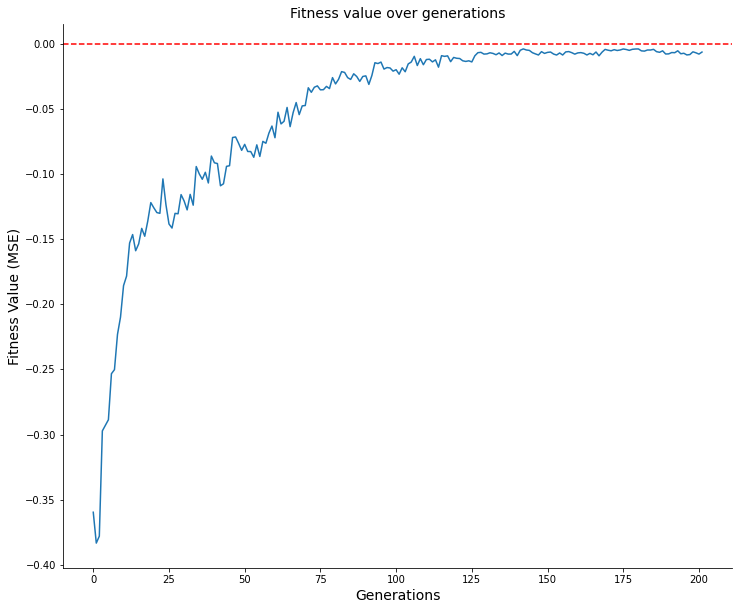

In [35]:
generations_array = np.arange(0, generations + 1, 1)

plt.figure(figsize=(12, 10))

plt.title('Fitness value over generations', fontsize=14) 
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Fitness Value (MSE)', fontsize=14)
sns.despine()

plt.plot(generations_array, best_organism_scores)
plt.axhline(y=0, color='r', linewidth=1.5, linestyle='dashed')
plt.show()

## Refferences

[Mediun article - Evolving Neural Networks](https://towardsdatascience.com/evolving-neural-networks-b24517bb3701)

[Paper randomly initiating weights](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

[Guia markdown](https://medium.com/walternascimentobarroso-pt/curso-r%C3%A1pido-de-markdown-4af49e3bfa65#:~:text=Para%20centralizar%20itens%20no%20markdown,usar%20a%20tag%20.)

[Activation functions article](https://usernamejack.medium.com/analyzing-the-activation-functions-of-common-neural-networks-4dcdaa92a055)